<a href="https://colab.research.google.com/github/nikitagrygoriev/CI/blob/master/ProjectCI_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preprocessing
###Importujemy biblioteki

In [0]:
import pandas as pd
import numpy as np

###Otwieramy opis danych

In [6]:
with open('imports-85.names', 'r') as f:
  print(f.read())

1. Title: 1985 Auto Imports Database

2. Source Information:
   -- Creator/Donor: Jeffrey C. Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
   -- Date: 19 May 1987
   -- Sources:
     1) 1985 Model Import Car and Truck Specifications, 1985 Ward's
        Automotive Yearbook.
     2) Personal Auto Manuals, Insurance Services Office, 160 Water
        Street, New York, NY 10038 
     3) Insurance Collision Report, Insurance Institute for Highway
        Safety, Watergate 600, Washington, DC 20037

3. Past Usage:
   -- Kibler,~D., Aha,~D.~W., \& Albert,~M. (1989).  Instance-based prediction
      of real-valued attributes.  {\it Computational Intelligence}, {\it 5},
      51--57.
	 -- Predicted price of car using all numeric and Boolean attributes
	 -- Method: an instance-based learning (IBL) algorithm derived from a
	    localized k-nearest neighbor algorithm.  Compared with a
	    linear regression prediction...so all instances
	    with missing attribute values were discarded.  This res

Z opisu wynika, że mamy `205` rekórdów 

###Ponieważ kolumny w zbiorze danych są nienazwane, podpisujemy

In [0]:
column_names = ['Symboling','Normalized_Losses','Make','Fuel_Type','Aspiration',
                'Num_Of_Doors','Body_Style','Drive_Wheels','Engine_Location',
                'Wheel_Base','Length','Width','Height','Curb_Weight','Engine_Type',
                'Num_Of_Cylinders','Engine_Size','Fuel_System','Bore','Stroke',
                'Compression_Ratio','Horsepower','Peak_RPM','City_MPG','Highway_MPG',
                'Price']

###Wczytujemy dane do zmiennnej `df` i sprawdzamy poprawność

In [8]:
df = pd.read_csv('imports-85.data',names=column_names,header=None)
df.head()

,Symboling,Normalized_Losses,Make,Fuel_Type,Aspiration,Num_Of_Doors,Body_Style,Drive_Wheels,Engine_Location,Wheel_Base,Length,Width,Height,Curb_Weight,Engine_Type,Num_Of_Cylinders,Engine_Size,Fuel_System,Bore,Stroke,Compression_Ratio,Horsepower,Peak_RPM,City_MPG,Highway_MPG,Price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


---
###Sprawdzamy czy ilość rekordów zgadza się z podaną w opisie




In [9]:
len(df)

205

---
###Usuwamy rekordy w których brakuje danych

In [10]:
for col in column_names:
 df = df[df[col] != '?']

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


###Sprawdzamy zależności ceny od innych zmiennych

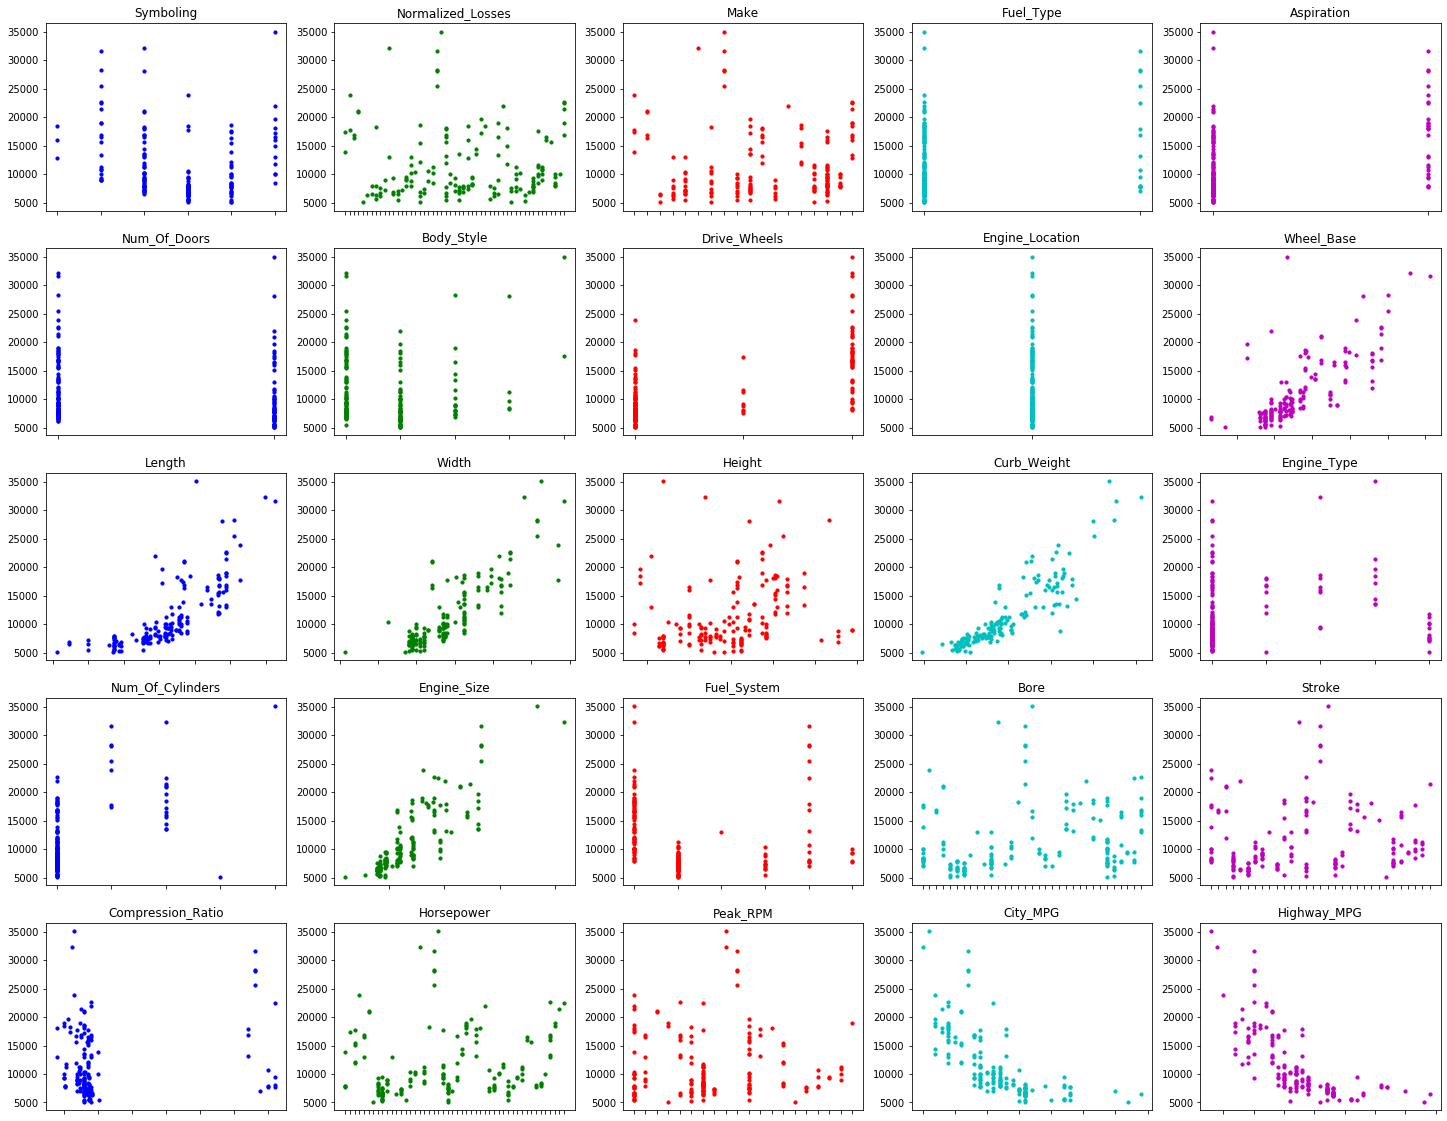

In [11]:
from matplotlib import pyplot as plt 
from matplotlib.pyplot import figure
from itertools import cycle

cycol = cycle('bgrcm')

target = ['Price'] 

def plotParams(df,parameters, ys):
  figure(figsize=(25, 20))  
  for (i,param) in enumerate(parameters):
    ax = plt.subplot(5,5,i+1)
    ax.title.set_text(param)
    ax.set_xticklabels([])
    plt.scatter(df[param].values.tolist(),df[ys].values.tolist(), s=10, c=next(cycol))

plotParams(df, column_names[:-1], target)

###Odrzucamy kolumny z nieciągłymi danymi

159

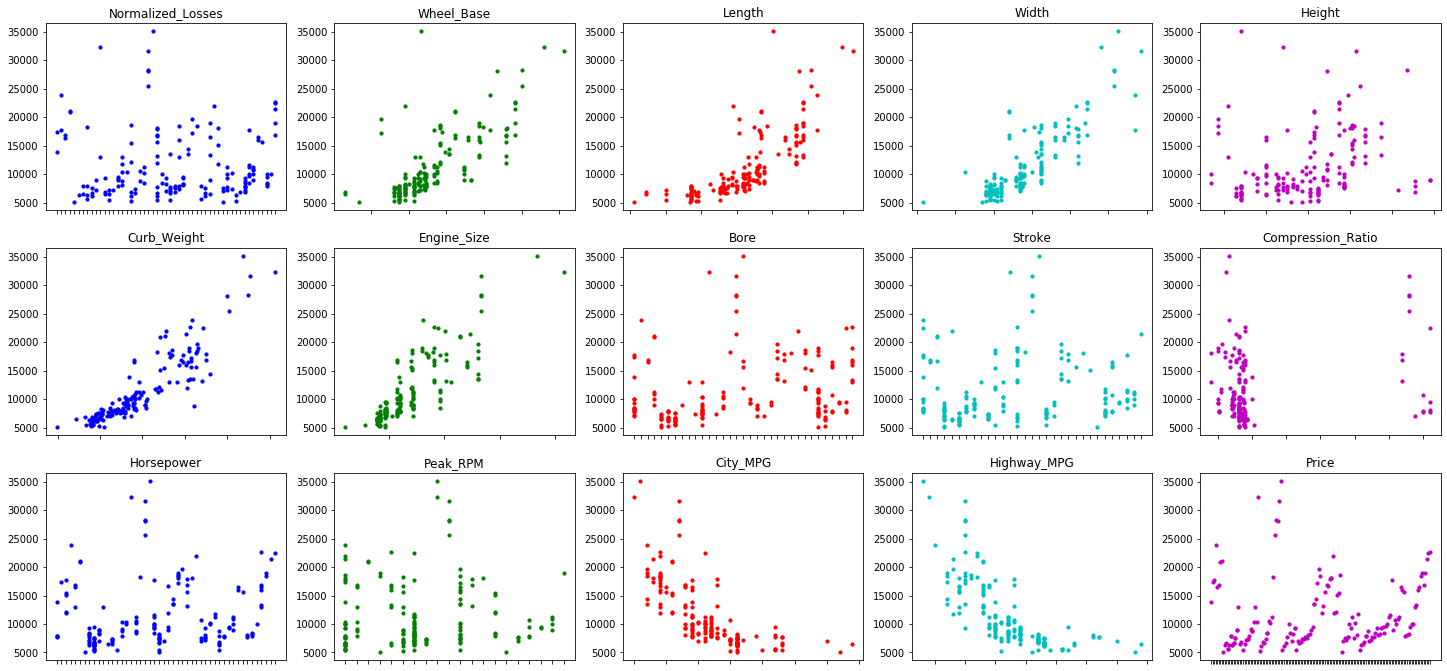

In [12]:
columns_cont = ['Normalized_Losses','Wheel_Base','Length','Width','Height',
              'Curb_Weight','Engine_Size','Bore','Stroke','Compression_Ratio',
              'Horsepower','Peak_RPM','City_MPG','Highway_MPG','Price']

df_clean = pd.DataFrame(columns=columns_cont)
df_clean[columns_cont] = df[columns_cont]
plotParams(df_clean, columns_cont, target)
len(df_clean)

###Z wykresów wynika, że najbardziej sensownymi danymi do regresji są:


`Wheel_Base, Length, Width, Curb_Weight, Engine_Size, City_MPG i Highway_MPG`

###Normalizujemy

In [0]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df_clean)
df_normalized = pd.DataFrame(x_scaled)
df_normalized.columns = columns_cont

#Regresja

###Piszemy funkcję do robienia regresji

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


def train(dataframe, parameters, target):
  
  X = pd.DataFrame(columns=parameters)
  y = pd.DataFrame(columns=target)      
  
  for col in parameters:
    X[col] = dataframe[col]
  for col in target:
    y[col] = dataframe[col]
  
  x_train, x_test, y_train,y_test = train_test_split(X,y)
  
  reg = LinearRegression()
  reg.fit(x_train, y_train)
  y_pred = reg.predict(x_test)

  x_test = [float(i) for i in x_test[parameters[0]].values]
  y_test = [float(i) for i in y_test['Price'].values]
  y_pred = [i[0] for i in y_pred]

  # print(y_pred)
  # print(y_test)
  # print(x_test)
  return y_pred, y_test, x_test

###Piszemy funkcję obliczającą błąd

In [0]:
def score(y_pred, y_test):
  y_pred_norm = np.asarray([float(i)/max(y_pred) for i in y_pred])
  y_test_norm = np.asarray([float(i)/max(y_test) for i in y_test])
  return np.mean(abs((y_pred_norm - y_test_norm)))

###Robimy wykres

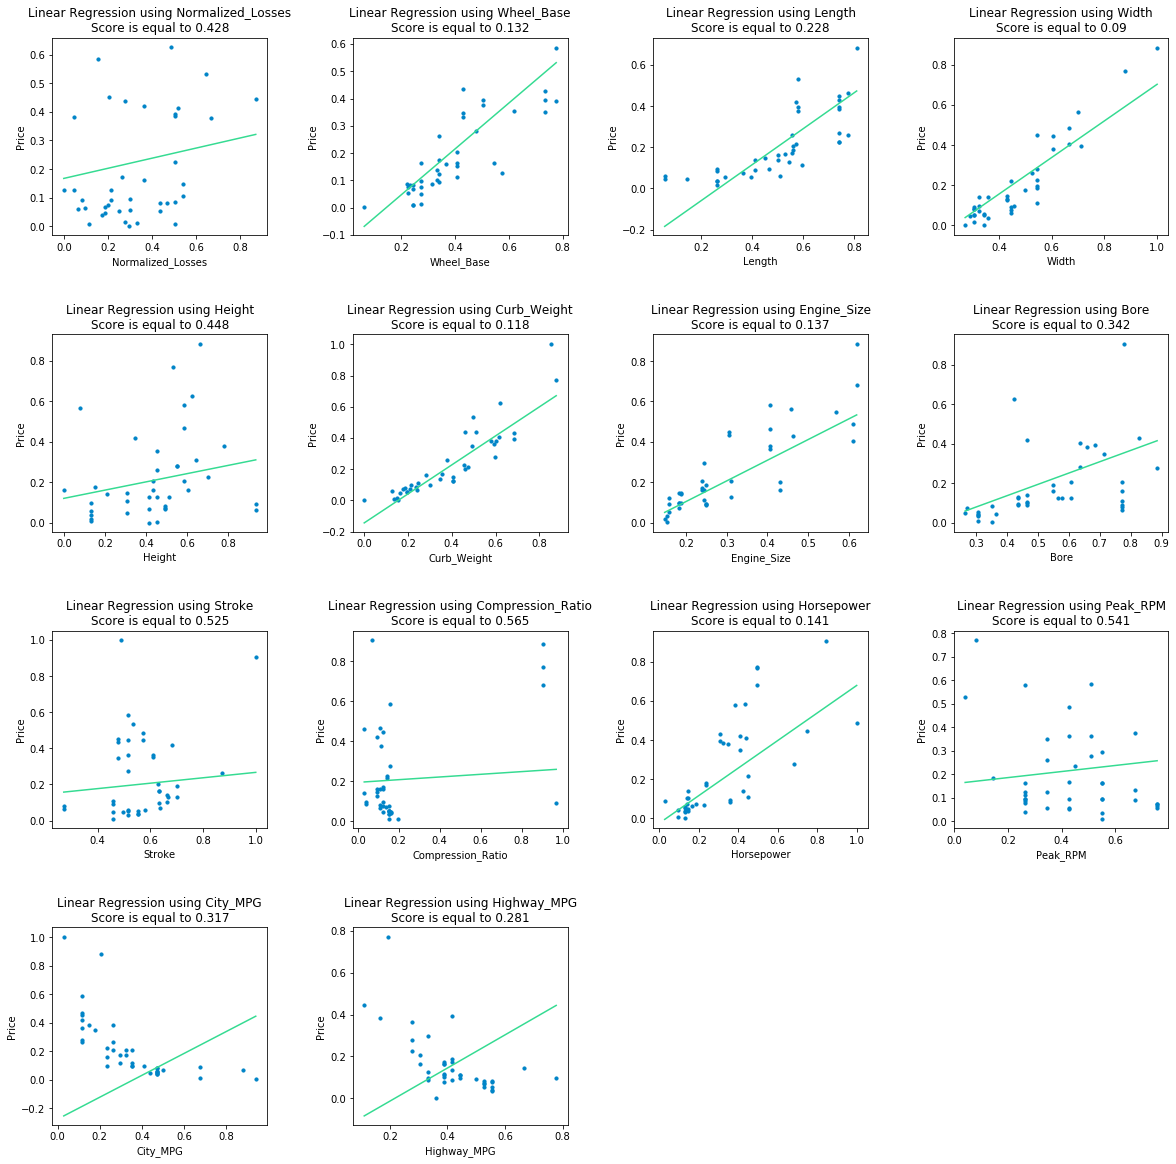

In [127]:
def plotRes(xs, ys, parameter, i, score):
  plt.subplot(4,4,i)
  plt.title(f'Linear Regression using {parameter}\nScore is equal to {round(score.pop(),3)}')
  plt.xlabel(parameter)
  plt.ylabel('Price')
  plt.plot([min(xs),max(xs)], [min(ys[0]),max(ys[0])],color='#35db92')  
  #plt.plot(xs,ys[0],color='#35db92')  
  plt.scatter(xs, ys[1],color='#0084c7',s=10)   
  

fig = figure(figsize=(20, 20))
plt.subplots_adjust(wspace=.4, hspace=.5)

for i in range(len(columns_cont)-1):
  pred, test, axis = train(df_normalized, [columns_cont[i]], ['Price'])
  plotRes(axis, [pred,test], columns_cont[i],i+1, {score(pred,test)})

plt.show()  

In [0]:
results = []
params = []

for i in range(100):
  for param in columns_cont[:-1]:
    pred, test, axis = train(df_clean, [param],['Price'])
    params.append(param)
    results.append(score(pred,test))

res = zip(params, results)
res = sorted(res, key=lambda x: x[1])
print(res[:3])